In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

c:\Users\minakshi.mathpal\Anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
SEED = 1
import torch
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [6]:
def load_data():
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_data = datasets.MNIST('data', train=True, download=True, transform=train_transform)
    test_data = datasets.MNIST('data', train=False, transform=test_transform)

    dataloader_args = dict(
        batch_size=128,
        num_workers=4,
        pin_memory=True,
        shuffle=True
    )

    train_loader = DataLoader(train_data, **dataloader_args)
    test_loader = DataLoader(test_data, **dataloader_args)

    return train_loader, test_loader


# Load data
train_loader, test_loader = load_data()

## Data Statistics

In [15]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


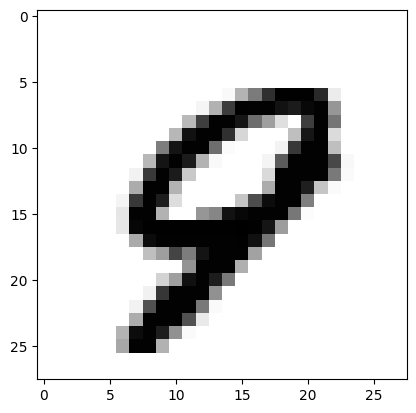

In [16]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

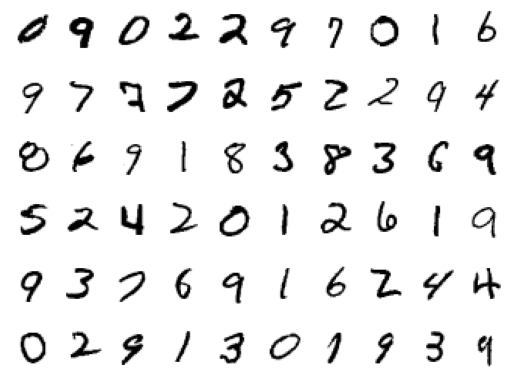

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    
    pbar.set_description(desc= f'LR={optimizer.param_groups[0]["lr"]} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [2]:
import torch.nn.functional as F
dropout_value = 0.005
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.pool2 = nn.MaxPool2d(2, 2)
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1) 
          ) # output_size = 1

        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     # nn.BatchNorm2d(10),
        #     # nn.ReLU(),
        #     # nn.Dropout(dropout_value)
        #  ) 
        self.fc = nn.Linear(16, 10, bias=False)
        
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x= self.pool2(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        # x = self.dropout(x.view(-1, 16))
        # x = self.fc(x)
        # x= self.convblock8(x)     
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             576
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             720
             ReLU-12             [-1, 10, 9, 9]               0
      BatchNorm2d-13             [-1, 10, 9, 9]              20
          Dropout-14             [-

In [ ]:
from io import StringIO
import sys

# Redirect stdout to a buffer
original_stdout = sys.stdout
summary_buffer = StringIO()
sys.stdout = summary_buffer

# Generate the summary
summary(model, input_size=(1, 28, 28))

# Restore stdout and write summary to a file
sys.stdout = original_stdout
with open('model_1_summary.txt', 'w') as f:
    f.write(summary_buffer.getvalue())

In [14]:
from torch.optim.lr_scheduler import StepLR
EPOCHS = 15
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=5e-5)
scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.003,
        epochs=EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.2,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1000.0
    )
sch_dict = scheduler.state_dict()
sch_dict['total_steps'] = sch_dict['total_steps'] + EPOCHS * int(len(train_loader))
scheduler.load_state_dict(sch_dict)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler)    
    test(model, device, test_loader)

EPOCH: 0


LR=0.000840929030019079 Loss=0.2907307744026184 Batch_id=468 Accuracy=77.06: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]   



Test set: Average loss: 0.3319, Accuracy: 9649/10000 (96.49%)

EPOCH: 1


LR=0.002281856861292636 Loss=0.17113524675369263 Batch_id=468 Accuracy=96.99: 100%|██████████| 469/469 [00:03<00:00, 118.89it/s] 



Test set: Average loss: 0.1177, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


LR=0.002999999766312519 Loss=0.10159694403409958 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:04<00:00, 115.07it/s]  



Test set: Average loss: 0.0813, Accuracy: 9829/10000 (98.29%)

EPOCH: 3


LR=0.0029486738546826213 Loss=0.03778668865561485 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:04<00:00, 116.52it/s] 



Test set: Average loss: 0.0539, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


LR=0.0027986273028036877 Loss=0.04349527880549431 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:04<00:00, 117.03it/s] 



Test set: Average loss: 0.0457, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


LR=0.002560085535222616 Loss=0.049818385392427444 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:03<00:00, 119.08it/s] 



Test set: Average loss: 0.0470, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


LR=0.002249304779191147 Loss=0.025416091084480286 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:03<00:00, 117.70it/s] 



Test set: Average loss: 0.0375, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


LR=0.001887464229643342 Loss=0.042314302176237106 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:03<00:00, 118.35it/s]  



Test set: Average loss: 0.0336, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


LR=0.0014992227220611033 Loss=0.01639152504503727 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:03<00:00, 118.20it/s]  



Test set: Average loss: 0.0320, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


LR=0.0011110382735867337 Loss=0.020575890317559242 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:03<00:00, 119.11it/s] 



Test set: Average loss: 0.0288, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


LR=0.0007493650128786283 Loss=0.007781928405165672 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:03<00:00, 119.07it/s] 



Test set: Average loss: 0.0270, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


LR=0.000438850374960721 Loss=0.00961659662425518 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:04<00:00, 116.36it/s]   



Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


LR=0.0002006554192574164 Loss=0.025685014203190804 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:03<00:00, 119.30it/s]  



Test set: Average loss: 0.0251, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


LR=5.101273836411788e-05 Loss=0.009656456299126148 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:03<00:00, 119.00it/s]  



Test set: Average loss: 0.0252, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


LR=1.2023368748134843e-07 Loss=0.03185105696320534 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:04<00:00, 116.57it/s]  



Test set: Average loss: 0.0246, Accuracy: 9937/10000 (99.37%)

